# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using Plots
using StatsBase

include("../../lib.jl")

ENV["LINES"]=30;

# Dataset

In [2]:
data = CSV.read("./data.csv")

,Class_Name,Left_Weight,Left_Distance,Right_Weight,Right_Distance
,String,Int64,Int64,Int64,Int64
1,B,1,1,1,1
2,R,1,1,1,2
3,R,1,1,1,3
4,R,1,1,1,4
5,R,1,1,1,5
6,R,1,1,2,1
7,R,1,1,2,2
8,R,1,1,2,3
9,R,1,1,2,4


In [3]:
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,Class_Name,,B,,R,3,,String
2,Left_Weight,3.0,1,3.0,5,,,Int64
3,Left_Distance,3.0,1,3.0,5,,,Int64
4,Right_Weight,3.0,1,3.0,5,,,Int64
5,Right_Distance,3.0,1,3.0,5,,,Int64


Look at class labels to see if dataset is imbalanced

In [4]:
label_counts = countmap(data[:(Class)])

LoadError: ArgumentError: column name :Class not found in the data frame

In [5]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

LoadError: UndefVarError: label_counts not defined

Get data ready for training

In [6]:
coerce!(data, :Class_Name=>Multiclass,
              :Left_Weight=>Continuous,
              :Right_Weight=>Continuous,
              :Left_Distance=>Continuous,
              :Right_Distance=>Continuous)
schema(data)

┌────────────────┬─────────────────────────────────┬───────────────┐
│ _.names        │ _.types                         │ _.scitypes    │
├────────────────┼─────────────────────────────────┼───────────────┤
│ Class_Name     │ CategoricalValue{String,UInt32} │ Multiclass{3} │
│ Left_Weight    │ Float64                         │ Continuous    │
│ Left_Distance  │ Float64                         │ Continuous    │
│ Right_Weight   │ Float64                         │ Continuous    │
│ Right_Distance │ Float64                         │ Continuous    │
└────────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 625


In [7]:
y, X = unpack(data, ==(:Class_Name), colname->true)

(CategoricalValue{String,UInt32}["B", "R", "R", "R", "R", "R", "R", "R", "R", "R"  …  "L", "L", "L", "L", "L", "L", "L", "L", "L", "B"], 625×4 DataFrame
│ Row │ Left_Weight │ Left_Distance │ Right_Weight │ Right_Distance │
│     │ Float64     │ Float64       │ Float64      │ Float64        │
├─────┼─────────────┼───────────────┼──────────────┼────────────────┤
│ 1   │ 1.0         │ 1.0           │ 1.0          │ 1.0            │
│ 2   │ 1.0         │ 1.0           │ 1.0          │ 2.0            │
│ 3   │ 1.0         │ 1.0           │ 1.0          │ 3.0            │
│ 4   │ 1.0         │ 1.0           │ 1.0          │ 4.0            │
│ 5   │ 1.0         │ 1.0           │ 1.0          │ 5.0            │
│ 6   │ 1.0         │ 1.0           │ 2.0          │ 1.0            │
│ 7   │ 1.0         │ 1.0           │ 2.0          │ 2.0            │
│ 8   │ 1.0         │ 1.0           │ 2.0          │ 3.0            │
│ 9   │ 1.0         │ 1.0           │ 2.0          │ 4.0            │
│ 10  │

Partition train and test data accoring to class labels

In [8]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:Class_Name])) # gives 70:30 split

([595, 102, 55, 568, 425, 389, 146, 63, 372, 250  …  195, 500, 571, 533, 112, 396, 297, 106, 303, 261], [444, 144, 546, 43, 19, 173, 365, 423, 27, 218  …  293, 614, 90, 471, 13, 134, 296, 79, 395, 415])

In [9]:
train_counts = countmap(data[train,:Class_Name])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

3-element Array{Float64,1}:
 0.0776255707762557
 0.4611872146118721
 0.4611872146118721

In [10]:
test_counts = countmap(data[test,:Class_Name])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

3-element Array{Float64,1}:
 0.08021390374331551
 0.45989304812834225
 0.45989304812834225

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [11]:
models(matching(X,y))

42-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [12]:
@load AdaBoostClassifier verbosity=2

import MLJScikitLearnInterface 

┌ Info: Loading into module "Main": 
└ @ MLJModels /home/andrew/.julia/packages/MLJModels/mUBFt/src/loading.jl:70


✔
import MLJScikitLearnInterface ✔


AdaBoostClassifier(
    base_estimator = nothing,
    n_estimators = 50,
    learning_rate = 1.0,
    algorithm = "SAMME.R",
    random_state = nothing) @335

### Boosting
* Implement or steal a boosted version of your decision trees. 
* As before, you will want to use some form of pruning, but presumably because you're using boosting you can afford to be much more aggressive about your pruning.

**Chooses the hardest examples** talk about in write-up

In [13]:
boost_model = AdaBoostClassifier(random_state=123)

AdaBoostClassifier(
    base_estimator = nothing,
    n_estimators = 50,
    learning_rate = 1.0,
    algorithm = "SAMME.R",
    random_state = 123) @887

In [14]:
boost_mach = machine(boost_model, X, y)

Machine{AdaBoostClassifier} @987 trained 0 times.
  args: 
    1:	Source @137 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @071 ⏎ `AbstractArray{Multiclass{3},1}`


In [15]:
fit!(boost_mach, rows=train, verbosity=2)

┌ Info: Training Machine{AdaBoostClassifier} @987.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{AdaBoostClassifier} @987 trained 1 time.
  args: 
    1:	Source @137 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @071 ⏎ `AbstractArray{Multiclass{3},1}`


In [16]:
boost_acc = evaluate!(boost_mach, resampling=CV(shuffle=true), measure=[cross_entropy, acc], 
                      verbosity=1, check_measure=false)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:05


┌───────────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                 │
├───────────────┼───────────────┼────────────────────────────────────────────┤
│ cross_entropy │ 1.0           │ [1.01, 1.0, 1.0, 1.01, 1.0, 0.997]         │
│ acc           │ 0.907         │ [0.838, 0.894, 0.913, 0.942, 0.923, 0.933] │
└───────────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [[[1.01, 1.01, ..., 1.03], [1.09, 1.07, ..., 0.93], [0.912, 1.01, ..., 1.07], [1.05, 0.917, ..., 1.08], [1.08, 0.928, ..., 0.937], [1.0, 1.08, ..., 1.1]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [17]:
# evaluate!(boost_mach, resampling=CV(shuffle=true), measure=[tnr,tpr,fnr,fpr], verbosity=1, operation=predict_mode)

In [18]:
fitted_params(boost_mach);

### GridSearch 
number of estimators vs learning rate

In [172]:
param1 = :learning_rate
param2 = :n_estimators

# r1 = range(boost_model, param1, lower=5*10^-1.5, upper=0.6, scale=:linear)
# r2 = range(boost_model, param2, lower=1, upper=5, scale=:linear)
r1 = range(boost_model, param1, lower=10^-2, upper=2*10^0, scale=:log10)
r2 = range(boost_model, param2, lower=1, upper=50, scale=:linear)

MLJBase.NumericRange(Int64, :n_estimators, ... )

In [173]:
self_tuning_boost_model = TunedModel(model=boost_model,
                                    tuning=Grid(goal=250),
                                    resampling=CV(), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = AdaBoostClassifier(
            base_estimator = nothing,
            n_estimators = 50,
            learning_rate = 1.0,
            algorithm = "SAMME.R",
            random_state = 123),
    tuning = Grid(
            goal = 250,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Float64,…} @504, NumericRange{Int64,…} @425],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @010

In [174]:
self_tuning_boost = machine(self_tuning_boost_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @145 trained 0 times.
  args: 
    1:	Source @481 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @051 ⏎ `AbstractArray{Multiclass{3},1}`


In [175]:
z = fit!(self_tuning_boost, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @145.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 256 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 256 metamodels: 100%[=========================] Time: 0:00:52


Machine{ProbabilisticTunedModel{Grid,…}} @145 trained 1 time.
  args: 
    1:	Source @481 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @051 ⏎ `AbstractArray{Multiclass{3},1}`


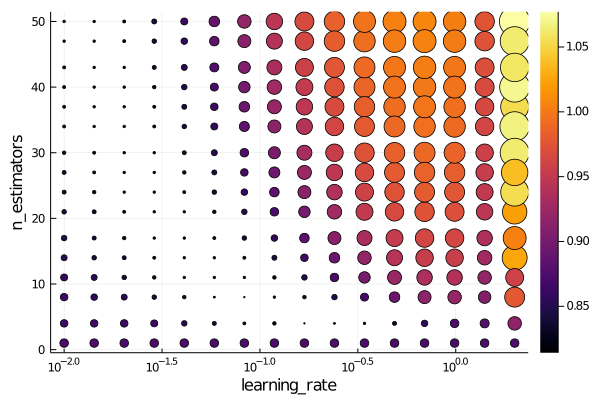

In [176]:
plot(self_tuning_boost)

In [162]:
best = fitted_params(self_tuning_boost)
best.best_model

AdaBoostClassifier(
    base_estimator = nothing,
    n_estimators = 5,
    learning_rate = 0.15333333333333332,
    algorithm = "SAMME.R",
    random_state = 123) @930

In [163]:
best_loss = round(z.report.best_result.measurement[1],digits=5)

0.80937

In [164]:
best_n = best.best_model.n_estimators
best_lr = best.best_model.learning_rate

0.15333333333333332

In [177]:
fn = "Figures/Boost_MCC"
png(replace(fn,'.' => ','))

### Learning Curves

In [165]:
data_schedule, training_losses, valid_losses = learn_curve(best.best_model, X[train,:], y[train], acc)

(d, train_metric, valid_metric) = (10, 1.0, 0.38636363636363635)
(d, train_metric, valid_metric) = (15, 0.9333333333333333, 0.6477272727272727)
(d, train_metric, valid_metric) = (20, 0.95, 0.6477272727272727)
(d, train_metric, valid_metric) = (25, 0.88, 0.625)
(d, train_metric, valid_metric) = (30, 0.8, 0.6363636363636364)
(d, train_metric, valid_metric) = (35, 0.8, 0.6704545454545454)
(d, train_metric, valid_metric) = (40, 0.85, 0.8181818181818182)
(d, train_metric, valid_metric) = (45, 0.7555555555555555, 0.75)
(d, train_metric, valid_metric) = (50, 0.78, 0.75)
(d, train_metric, valid_metric) = (55, 0.8181818181818182, 0.8068181818181818)
(d, train_metric, valid_metric) = (60, 0.8333333333333334, 0.8068181818181818)
(d, train_metric, valid_metric) = (65, 0.8, 0.8068181818181818)
(d, train_metric, valid_metric) = (70, 0.7857142857142857, 0.8068181818181818)
(d, train_metric, valid_metric) = (75, 0.7866666666666666, 0.8068181818181818)
(d, train_metric, valid_metric) = (80, 0.7625, 0.7

(10:5:350, Any[1.0, 0.9333333333333333, 0.95, 0.88, 0.8, 0.8, 0.85, 0.7555555555555555, 0.78, 0.8181818181818182  …  0.8098360655737705, 0.8129032258064516, 0.7301587301587301, 0.725, 0.7661538461538462, 0.7242424242424242, 0.7820895522388059, 0.7676470588235295, 0.7507246376811594, 0.7314285714285714], Any[0.38636363636363635, 0.6477272727272727, 0.6477272727272727, 0.625, 0.6363636363636364, 0.6704545454545454, 0.8181818181818182, 0.75, 0.75, 0.8068181818181818  …  0.8181818181818182, 0.8181818181818182, 0.7272727272727273, 0.7272727272727273, 0.7386363636363636, 0.7272727272727273, 0.8068181818181818, 0.7386363636363636, 0.7613636363636364, 0.7272727272727273])

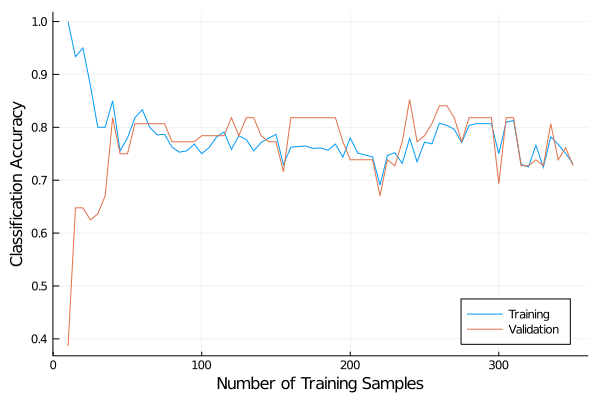

In [178]:
plot(data_schedule, training_losses, label="Training", legend=:bottomright)
plot!(data_schedule, valid_losses, label="Validation")
xlabel!("Number of Training Samples")
ylabel!("Classification Accuracy")

In [179]:
fn = "Figures/Boost_LC"
png(replace(fn,'.' => ','))

# Final Results

In [180]:
final_boost_model = best.best_model

AdaBoostClassifier(
    base_estimator = nothing,
    n_estimators = 5,
    learning_rate = 0.15333333333333332,
    algorithm = "SAMME.R",
    random_state = 123) @930

In [181]:
Final_Boost = machine(final_boost_model, X, y)

Machine{AdaBoostClassifier} @211 trained 0 times.
  args: 
    1:	Source @150 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @850 ⏎ `AbstractArray{Multiclass{3},1}`


In [182]:
fit!(Final_Boost, rows=train, verbosity=2)

┌ Info: Training Machine{AdaBoostClassifier} @211.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{AdaBoostClassifier} @211 trained 1 time.
  args: 
    1:	Source @150 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @850 ⏎ `AbstractArray{Multiclass{3},1}`


In [183]:
ŷ2 = MLJ.predict(Final_Boost, X[test,:]);

In [184]:
cross_entropy(ŷ2, y[test]) |> mean

0.8099999038305038

In [185]:
acc(ŷ2, y[test])

0.7700534759358288

In [186]:
c = confusion_matrix(mode.(ŷ2), y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["B", "L", "R"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │      B      │      L      │      R      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      B      │      0      │      0      │      0      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      L      │      9      │     72      │     14      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      R      │      6      │     14      │     72      │
└─────────────┴─────────────┴─────────────┴─────────────┘


In [189]:
(9+6)/(9+6+0)

1.0

In [190]:
(14)/(14+72+0)

0.16279069767441862

In [191]:
misclassification_rate(c)

0.22994652406417115